This project exercise aims to conduct Data Exploration and Preprocessing on the MBA Dataset which has missing values, outliers, imbalanced dataset, and irrelevant features. Proper techniques and feature selection methods are employed to further refine the dataset and features.

In [1]:
# Load all necessary packages for the activity and locate the dataset in the Google Drive

import seaborn as sns
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from pathlib import Path
from google.colab import drive
drive.mount('/gdrive')
file_path = '/gdrive/My Drive/AY24-25 Term 1/DATA103/Datasets/MBA 2.csv'

Mounted at /gdrive


Data Exploration and Preprocessing

In [2]:
# Read the dataset and perform initial EDA to analyze missing data, outliers, class distribution, and categorical features that need to be encoded
df = pd.read_csv(file_path)
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [3]:
df.shape

(6194, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


From the datatypes shown above, there is a need to transform categorical features such as (1) Gender, (2) Major, (3) Race, (4) Work Industry, and (5) Admission into numerical features. Furthermore, the boolean feature 'International' also needs to be transformed into 1 and 0 being True and False respectively

In [5]:
df.describe()

,application_id,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000,6194.000000
mean,3097.500000,3.250714,651.092993,5.016952
std,1788.198115,0.151541,49.294883,1.032432
min,1.000000,2.650000,570.000000,1.000000
25%,1549.250000,3.150000,610.000000,4.000000
50%,3097.500000,3.250000,650.000000,5.000000
75%,4645.750000,3.350000,680.000000,6.000000
max,6194.000000,3.770000,780.000000,9.000000


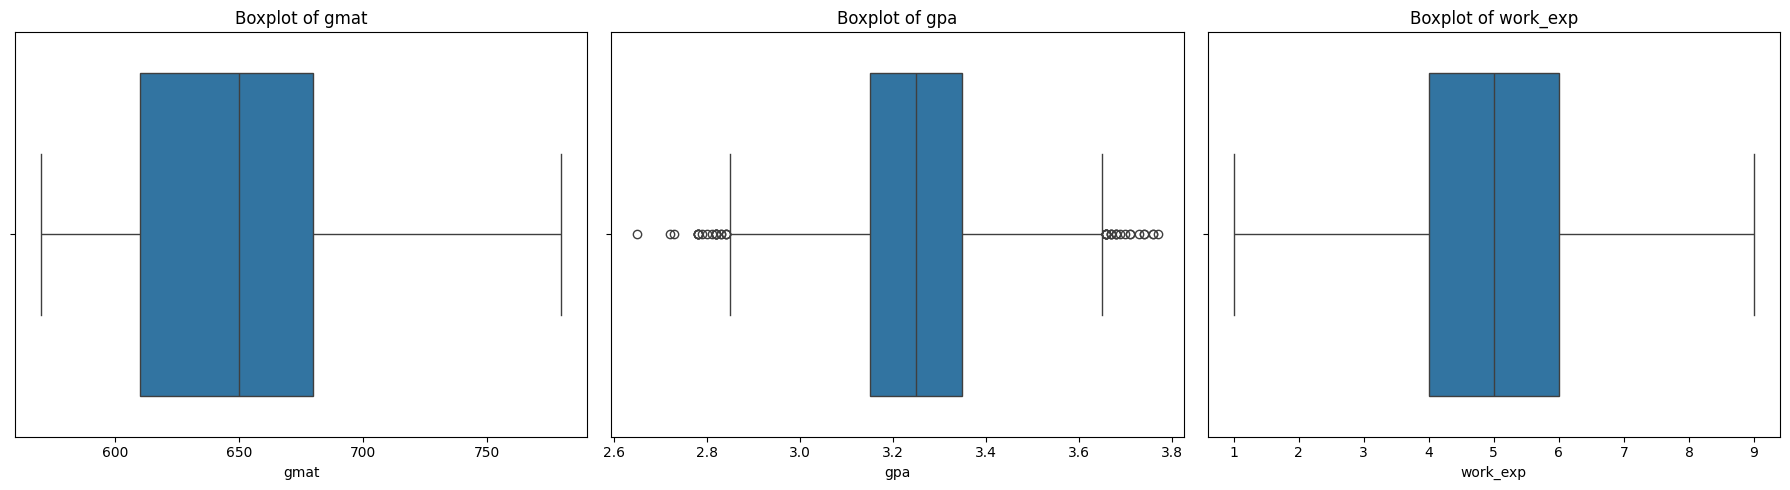

In [6]:
# Checking for numerical outliers
num_features = ['gmat', 'gpa', 'work_exp']

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot each feature in a separate subplot
for i, feature in enumerate(num_features):
    sns.boxplot(x=df[feature], ax=axs[i])
    axs[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [7]:
# Function to identify and remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Removing rows with outliers
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean

# Apply to each numerical column where outliers are suspected
for column in num_features:
    df = remove_outliers_iqr(df, column)

# Check the shape of the dataset after outlier removal
print(df.shape)

(6150, 10)


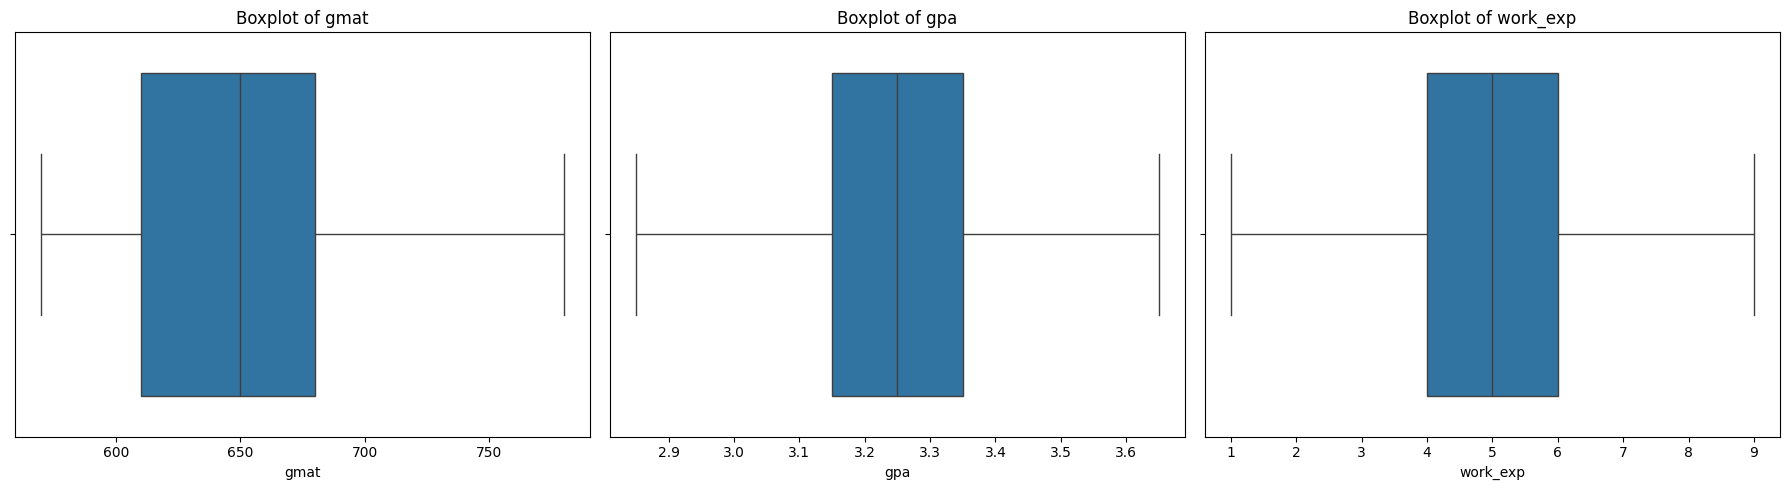

In [8]:
# Boxplot after removing outliers
# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot each feature in a separate subplot
for i, feature in enumerate(num_features):
    sns.boxplot(x=df[feature], ax=axs[i])
    axs[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

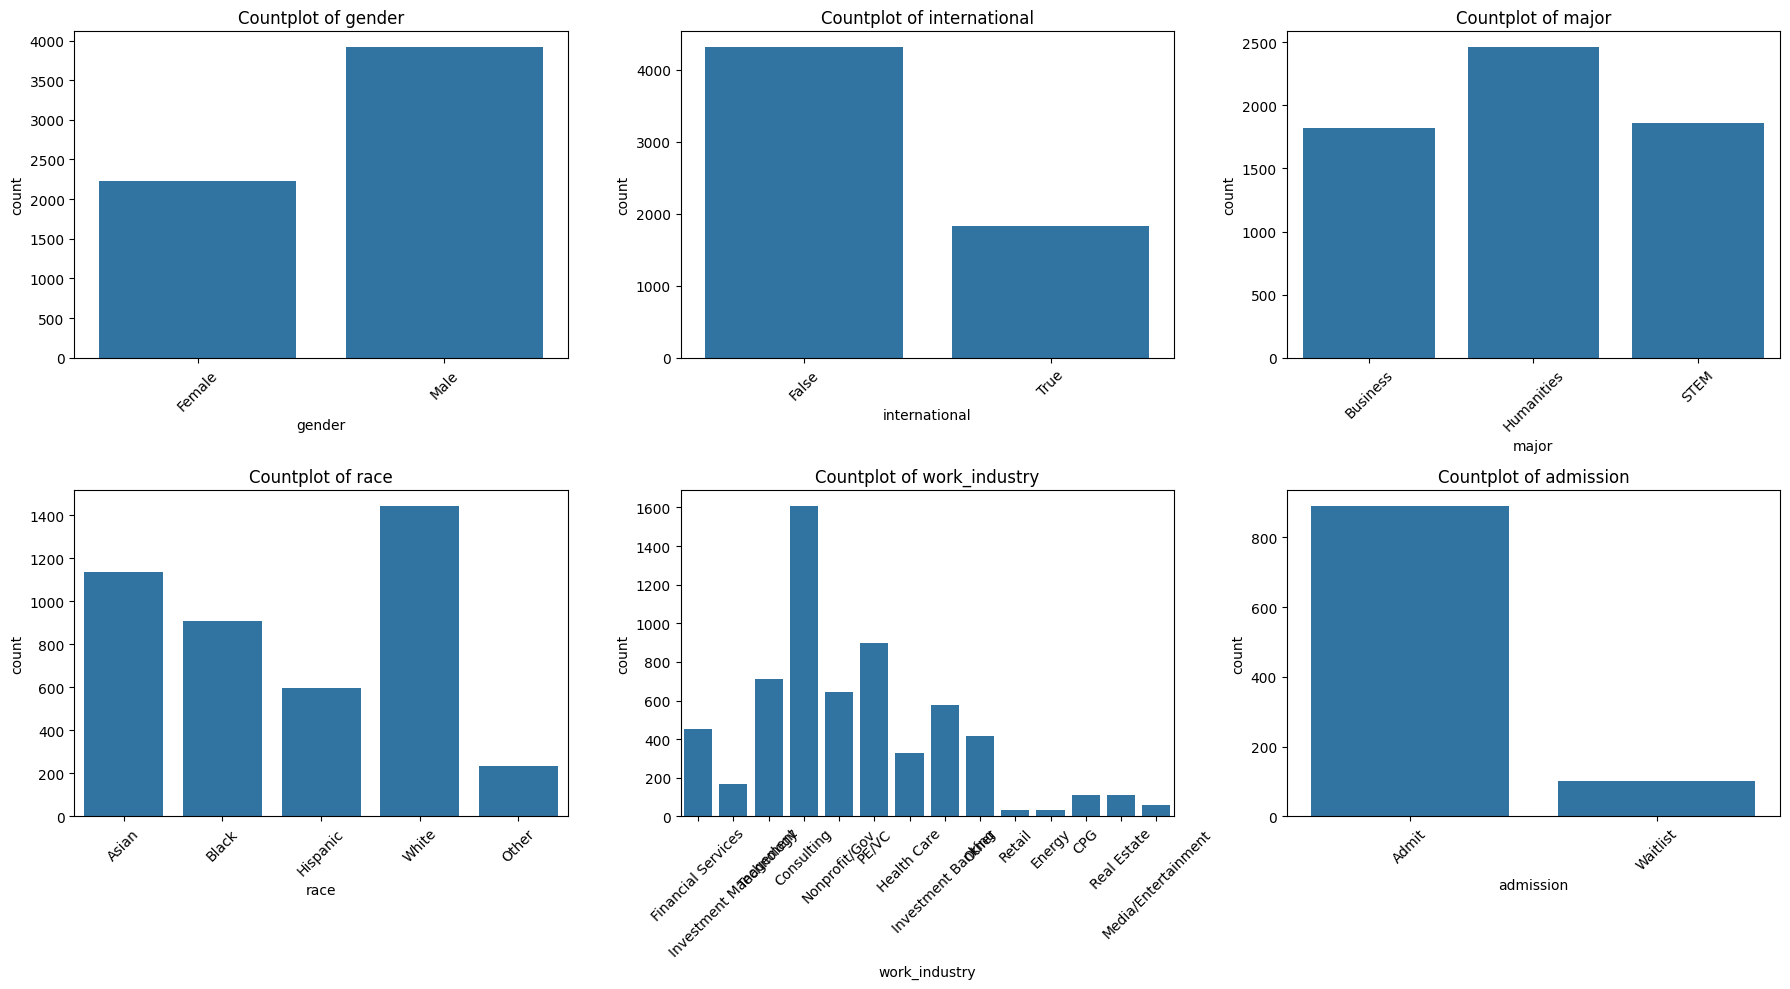

In [9]:
# Define categorical features
cat_features = ['gender', 'international','major', 'race', 'work_industry', 'admission']

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns (adjust height to 10)

# Flatten the axs array to easily iterate through it
axs = axs.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(cat_features):
    sns.countplot(x=df[feature], ax=axs[i])
    axs[i].set_title(f'Countplot of {feature}')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate labels if necessary

# Adjust layout
plt.tight_layout()
plt.show()

Looking at the bar graphs, it can be observed that most of the categorical values belong to their proper classificaiton with sufficient values. Hence, there is no observed outliers for the categorical features. However, the bar chart also tells us that most of the categorical features are imbalanced which needs to be addressed later.

Checking for missing values

In [10]:
# Check for missing values
df.isna().sum()

,0
application_id,0
gender,0
international,0
gpa,0
major,0
race,1832
gmat,0
work_exp,0
work_industry,0
admission,5159


Race and admission are identified to have null values. According to the Kaggle website where the dataset is sourced, when Admission is denied, it corresponds to a null value in the Admission target variable, while null values to the categorical feature race corresponds to the student either an International student or other. Nonetheless, there is a need to determine if these missing values are MNAR, MAR, and MCAR.  

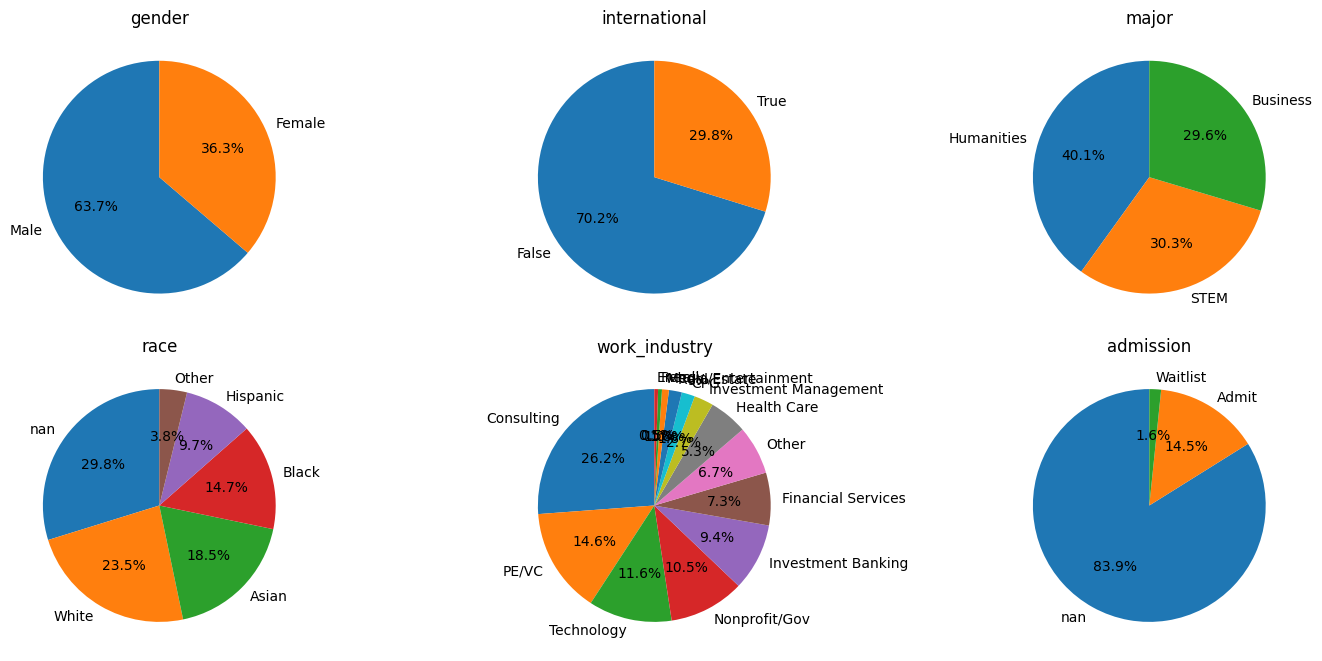

In [11]:
# Show the distribution of features and target variable together with the missing values
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns

plt.figure(figsize=(15, 10))

# Create a loop for creating the pie charts
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)  # Adjust based on the number of features

    # Include null values in the counts
    value_counts = df[feature].value_counts(dropna=False)  # dropna=False includes NaN counts

    # Plot pie chart
    value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(feature)
    plt.ylabel('')  # Hide the y-label for better visual appeal

plt.tight_layout()
plt.show()

The pie chart supports the argument above that most of the categorical features are imbalanced. Furthermore, it can be observed from the Race categorical feature and Admission target variable that there is a significant share contribution of missing values in the dataset that needs to be addressed.

Determining the type of missing value and dealing with missing values on 'Race' categorical feature and 'Admission' target variable


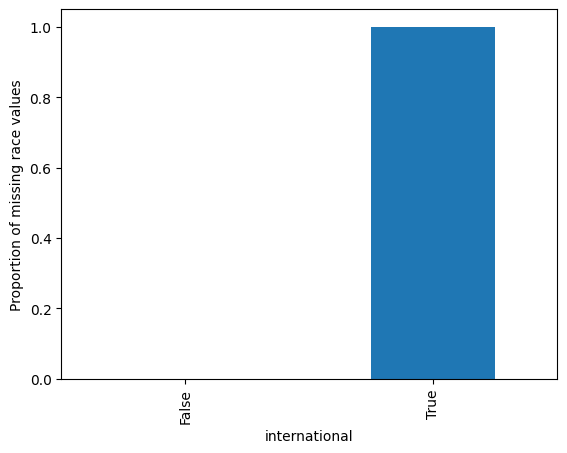

In [12]:
df.groupby('international')['race'].apply(lambda x: x.isnull().mean()).plot(kind='bar')
plt.ylabel('Proportion of missing race values')
plt.show()

From the bar chart above, it tells us that 100% of the missing values from race is also when International boolean feature is True. As such, it can be inferred that this missing value is Missing At Random (MAR) since missing is related to an observed variables in the dataset, which is International. To handle this missingness, we can impute values in the missing data of race with 'Other'

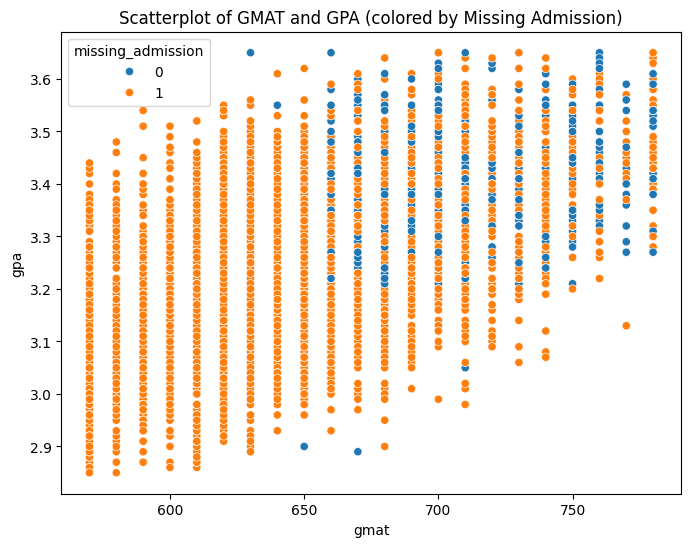

In [13]:
# Check if the missing values of Admission is associated with an observed variables
df['missing_admission'] = df['admission'].isnull().astype(int)  # 1 for missing, 0 for present

plt.figure(figsize=(8, 6))
sns.scatterplot(x='gmat', y='gpa', hue='missing_admission', data=df)
plt.title('Scatterplot of GMAT and GPA (colored by Missing Admission)')
plt.show()

From the scatterplot of numerical features such as GMAT and GPA in relation to values of admission wherein the blue dots can either be Admit or Waitlisted while the orange dots are Denied students, it can be inferred that most of the blue dots would group together in the upper right of the graph, pertaining that if GMAT and GPA are high, there is a higher chance that the student will either be Admitted or Waitlisted. There seems to be a positive relationship given the upward parallel line of the scatterplot.

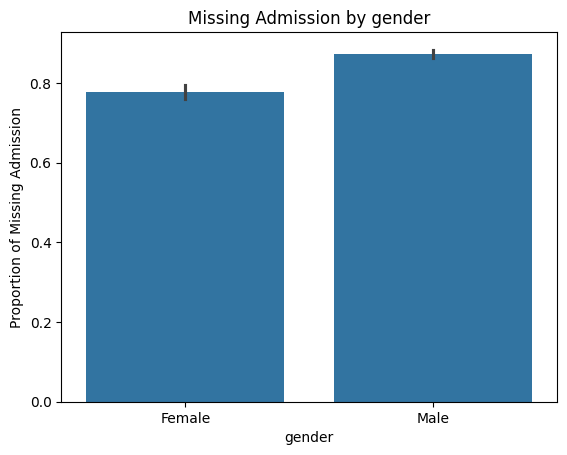

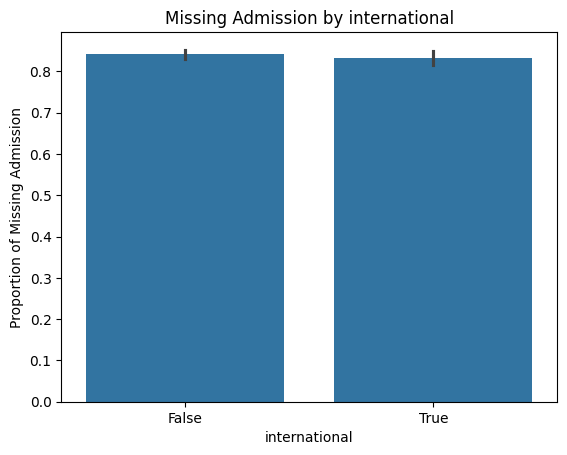

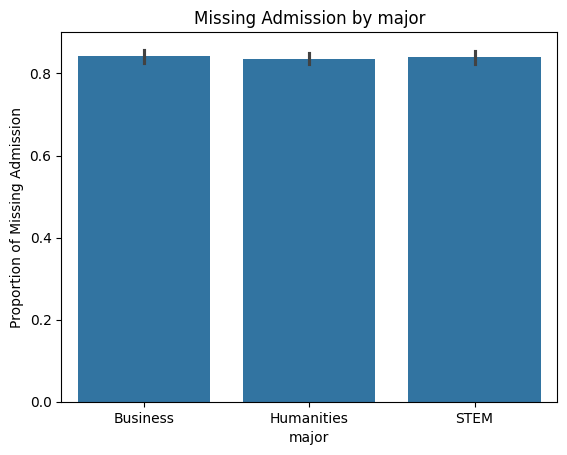

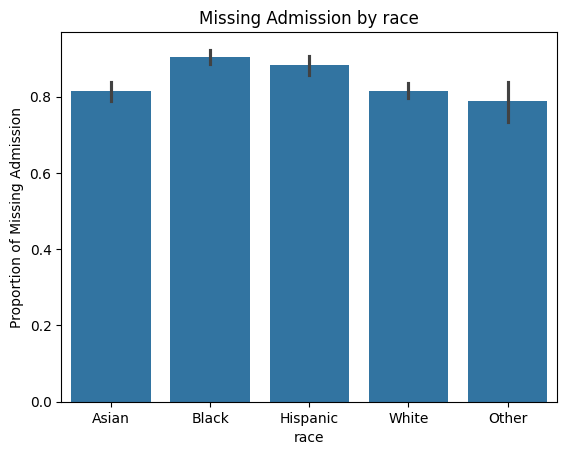

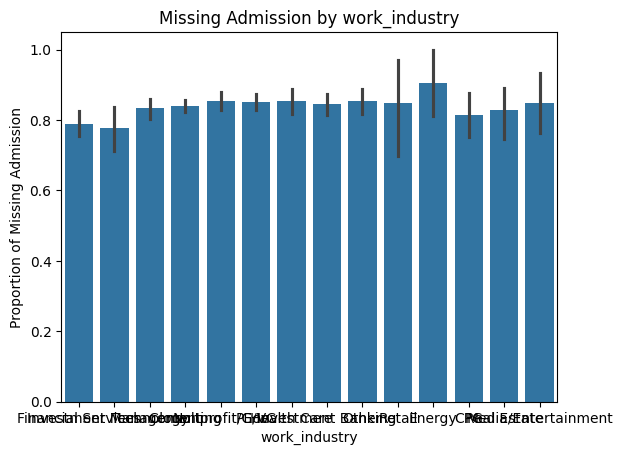

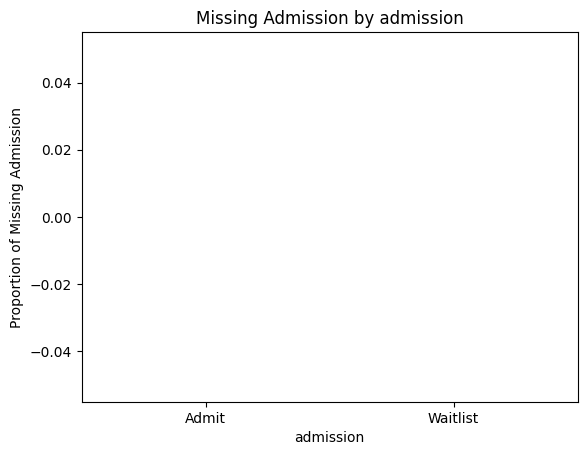

In [14]:
# Function to create bar plots for missing admission values
def barplot_for_missing(feature):
    sns.barplot(x=feature, y='missing_admission', data=df)
    plt.title(f'Missing Admission by {feature}')
    plt.ylabel('Proportion of Missing Admission')
    plt.show()

# Apply bar plot for each categorical feature
for feature in categorical_features:
    barplot_for_missing(feature)

For the association of missing values of Admission with the categorical features, unlike the missing values of Race which is 100% associated with International boolean feature as True, this time it is evenly spread across the various categorical values of the features and as such, the missing values of Admission is not associated with these categorical features.

Therefore, while it can be said that while having a higher GMAT and GPA will likely result in Admit or Waitlist status, it is still not guaranteed as there are also orange dots in upper left of the scatterplots. Moreover, the categorical features are not associated with the missing values of Admission, and it can be concluded that the missing values is not MAR, but rather MNAR since the Kaggle dataset source indicated that when Admission is null, it corresponds to denied. Given that, the missingness is related to the missing values themselves which could be due to the settings of how the data was collection or generated in which it omits denied statuses, or if people failed the MBA graduate program, they would likely avoid putting their Admission status as Denied since it can be embarassing.

The solution from the missing values of the Race categorical feature (MAR) and Admission target variable (MNAR) are data imputation and improving the dataset or finding data respectively. As such, both the missing values from the aforementioned feature and variable can be addressed using data imputation wherein the missing values of Race can be imputed with "Other" while the missing values of Admission can be imputed with "Denied." This is backed by the justification of the graphs showned above and the domain knowledge obtained from the Kaggle dataset source.

In [15]:
# Fill null values with the corresponding necessary data values
df['admission'].fillna('Denied', inplace=True)
df['race'].fillna('Other', inplace=True)

<ipython-input-15-8741ed1da151>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['admission'].fillna('Denied', inplace=True)
<ipython-input-15-8741ed1da151>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

After dealing with the missing values and outliers, the next step is to encode the categorical features into numerical values. For International and Admission, Label Encoding will be done to assign numerical values with ordinal scale to better capture the relationship when International is True with Admission and Admit status with the other features. However, it is important to note that International boolean feature will be dropped later at feature selection. This is just to showcase proper encoding.

In [16]:
# Apply Label Encoding for International boolean feature and Admission
label_encoder = preprocessing.LabelEncoder()

# Encode labels in the 'International' column
df['international'] = label_encoder.fit_transform(df['international'])

admission_mapping = {'Admit': 1, 'Waitlist': 0, 'Denied': -1}
df['admission'] = df['admission'].map(admission_mapping)

Apply Frequency Encoding to encode numerical values and also at the same time, address the imbalanced data from gender, major, race, and work industry as observed from the bar charts and pie charts


In [17]:
# Apply Frequency Encoding on gender, major, race, and work industry

# List of categorical features for frequency encoding
categorical_features = ['gender', 'major', 'race', 'work_industry']

# Function to perform frequency encoding
def frequency_encoding(df, column):
    frequency = df[column].value_counts(normalize=True)  # Calculate frequency
    df[column] = df[column].map(frequency)  # Map frequencies back to the DataFrame

# Apply frequency encoding to each categorical feature
for feature in categorical_features:
    frequency_encoding(df, feature)

Drop Application ID as it does not contribute to predicting Admission status

In [18]:
# Drop Application ID and Missing Admission
df = df.drop('application_id', axis=1)
df = df.drop('missing_admission', axis=1)

In [19]:
df

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,0.362602,0,3.30,0.296423,0.184553,620.0,3.0,0.073171,1
1,0.637398,0,3.28,0.400650,0.147480,680.0,5.0,0.026992,-1
2,0.362602,1,3.30,0.296423,0.336260,710.0,5.0,0.115772,1
3,0.637398,0,3.47,0.302927,0.147480,690.0,6.0,0.115772,-1
4,0.637398,0,3.35,0.302927,0.096748,590.0,5.0,0.261789,-1
...,...,...,...,...,...,...,...,...,...
6189,0.637398,0,3.49,0.296423,0.234959,640.0,5.0,0.067480,-1
6190,0.637398,0,3.18,0.302927,0.147480,670.0,4.0,0.261789,-1
6191,0.362602,1,3.22,0.296423,0.336260,680.0,5.0,0.053496,1
6192,0.637398,1,3.36,0.296423,0.336260,590.0,5.0,0.067480,-1


Feature Selection

For feature selection, Pearson Correlation, Random Forest Feature Importance, Mutual Information, and Recursive Feature Elimination will be applied to check which features are significant and retained while otherwise will be droppped.

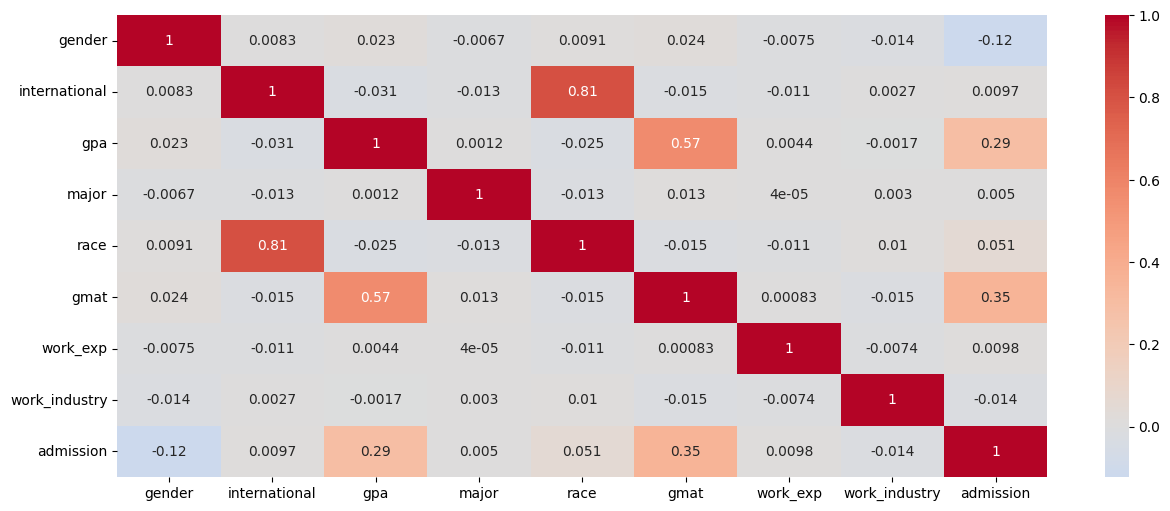

In [20]:
df_corr = df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(df_corr, annot=True,  cmap="coolwarm", center=0)
plt.show()

In research studies, it is commonly accepted that an r ≥ 0.7 indicates a high correlation, so International and race has a high correlation and one of these two features is subjected to being dropped. The other feature selections can further help us identify which features to drop. The correlation between GMAT and GPA is still acceptable because it is below 0.7, and these two features are seen to have a higher correlation score for admission than the other features.

         Feature  Permutation Importance (60%)  Gini Importance (40%)  \
2            gpa                      0.008927               0.124271   
5           gmat                      0.015122               0.110792   
7  work_industry                      0.004390               0.059020   
6       work_exp                      0.002537               0.039286   
4           race                      0.005512               0.026421   
3          major                      0.004927               0.021821   
0         gender                      0.007659               0.011799   
1  international                      0.006049               0.006589   

   Combined Score  
2        0.133197  
5        0.125913  
7        0.063410  
6        0.041823  
4        0.031933  
3        0.026748  
0        0.019458  
1        0.012638  


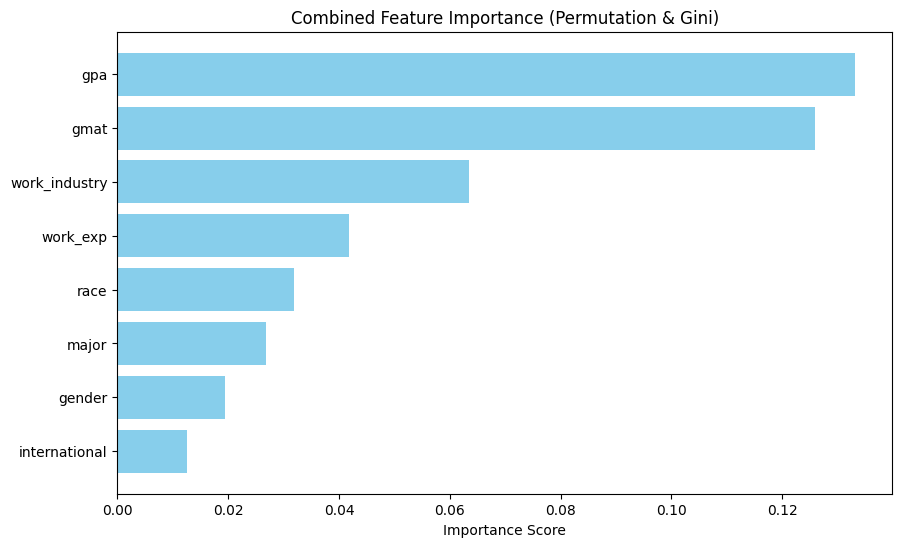

In [21]:
# Implement Random Forest Feature Importance with weights (60% from Permutation Importance and 40% from Gini Importance)

# Load dataset and define X (features) and y (target)
X = df.drop('admission', axis=1)
y = df['admission']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


# -------------------------- #
# 1. Permutation Importance
# -------------------------- #
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Get the feature importance values and scale to 60%
perm_scores = perm_importance.importances_mean * 0.60

# -------------------------- #
# 2. Gini Importance (from Random Forest)
# -------------------------- #
gini_scores = rf.feature_importances_ * 0.40

# -------------------------- #
# 3. Combine and Rank the Scores
# -------------------------- #
# Combine both scores
combined_scores = perm_scores + gini_scores

# Create DataFrame to store and rank features
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance (60%)': perm_scores,
    'Gini Importance (40%)': gini_scores,
    'Combined Score': combined_scores
})

# Sort by combined score to rank features by importance
feature_importance_df = feature_importance_df.sort_values(by='Combined Score', ascending=False)

# Display the ranked features
print(feature_importance_df)

# -------------------------- #
# Plot the Combined Importance
# -------------------------- #
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Combined Score'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Combined Feature Importance (Permutation & Gini)')
plt.gca().invert_yaxis()
plt.show()

Random Forest Feature Importance tells us that GMAT and GPA are the top features that are important compared to the rest of the features. Next to these are work industry and work experience. International is ranked last so this gives more emphasis on dropping this feature. Following these are Gender, Major, and Race so these features are also subject to dropping.

In [22]:
# Mutual Information
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame for mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

# Sort by MI score
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
print(mi_df)

         Feature  MI Score
5           gmat  0.081400
2            gpa  0.057492
4           race  0.013445
0         gender  0.008968
7  work_industry  0.004120
1  international  0.000000
3          major  0.000000
6       work_exp  0.000000


Mutual Information is a statistical measure used to quantify the amount of information obtained about one variable through another variable. A value of 0 indicates that the two variables are independent (knowing one gives no information about the other). Higher values indicate a stronger relationship. From the results, international and work experience gives no information to admission. GMAT and GPA are once again the highest scores that give more information to admission. Major and race have also noticeable lower Mutual information score which is also subject to dropping.

Lastly is the Recursive Feature Elimination, which basically tells us which features to include and also shows the accuracy of the model as more or less features are added.

In [23]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()

# You may experiment with other estimators, but Gradient Boosting Classifier will be used as an example
#estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
#estimator = LogisticRegression()
#estimator = DecisionTreeClassifier()
#estimator = RandomForestClassifier()

selector = RFE(estimator, n_features_to_select=7, step=1)
selector.fit(X_train, y_train)



RFE(estimator=GradientBoostingClassifier(), n_features_to_select=7)

In [24]:
X_train.columns[selector.get_support()]

Index(['gender', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry'], dtype='object')

In [25]:
rfecv = RFECV(estimator=estimator, scoring='accuracy', min_features_to_select=3)
rfecv.fit(X, y)

RFECV(estimator=GradientBoostingClassifier(), min_features_to_select=3,
      scoring='accuracy')

In [26]:
rfecv.cv_results_

{'mean_test_score': array([0.82813008, 0.82422764, 0.82634146, 0.82845528, 0.82910569,
        0.82845528]),
 'std_test_score': array([0.00685246, 0.00941687, 0.00983169, 0.00932659, 0.00861021,
        0.00714338]),
 'split0_test_score': array([0.82520325, 0.81869919, 0.81788618, 0.82601626, 0.82926829,
        0.82926829]),
 'split1_test_score': array([0.83170732, 0.83333333, 0.83577236, 0.83170732, 0.83414634,
        0.82682927]),
 'split2_test_score': array([0.82195122, 0.81300813, 0.81788618, 0.81788618, 0.81869919,
        0.8203252 ]),
 'split3_test_score': array([0.8398374 , 0.83739837, 0.84065041, 0.84471545, 0.84227642,
        0.84146341]),
 'split4_test_score': array([0.82195122, 0.81869919, 0.8195122 , 0.82195122, 0.82113821,
        0.82439024]),
 'n_features': array([3, 4, 5, 6, 7, 8])}

In [27]:
list(range(1,len(rfecv.cv_results_['mean_test_score'])+1))

[1, 2, 3, 4, 5, 6]

Text(0, 0.5, 'Accuracy')

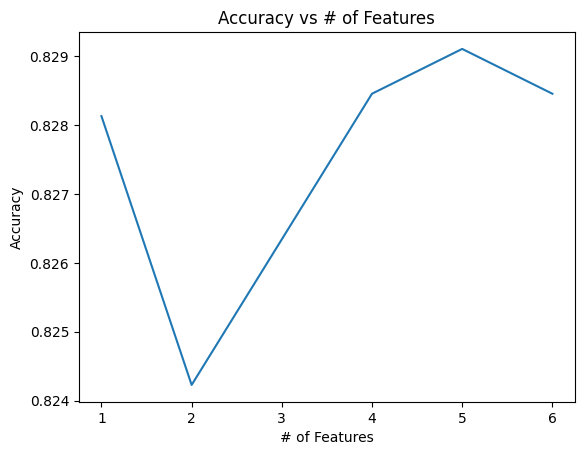

In [28]:
ax = sns.lineplot(x=list(range(1,len(rfecv.cv_results_['mean_test_score'])+1)),
                  y=list(rfecv.cv_results_['mean_test_score']))
ax.set_title("Accuracy vs # of Features")
ax.set_xlabel("# of Features")
ax.set_ylabel("Accuracy")

From this, the highest accuracy will be obtained when there are only 5 features to be inluced. However, the difference between 5 features and 6 features are not so huge in accuracy values so 6 features may still be used.

In [29]:
X_train.columns

Index(['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp',
       'work_industry'],
      dtype='object')

In [30]:
rfecv.support_

array([ True, False,  True,  True,  True,  True,  True,  True])

The results here tell us to exclude International boolean feature since it is not important.

In [31]:
temp_df = pd.DataFrame()
temp_df['feature'] = X_train.columns
temp_df['rank'] = rfecv.ranking_
temp_df_sorted = temp_df.sort_values(by='rank', ascending=True)
temp_df_sorted

,feature,rank
0,gender,1
2,gpa,1
3,major,1
4,race,1
5,gmat,1
6,work_exp,1
7,work_industry,1
1,international,2


The ranking above shows the importance of the features, with 1 as the highest and 2 as the lowest.

Given that there are consistent results in GMAT and GPA as important features, these will be retained. Given that there are mixed results in race, gender, work experience, and work industries, these features will also be retained. However, given major and international are always resulting in low scores (in addition with international highly correlated with race), these features will be dropped. Furthermore, following domain knowledge, having a higher GPA and GMAT indicates higher ability to pass MBA graduate scores. Being an international student or not does not really tell us information whether one is able to pass MBA since both domestic and international students may be admitted. For the rest of the variables since there are mixed results, it may be important to include them to capture nuanced relationships.

In [32]:
# Drop the variables according to feature selection

df = df.drop(columns=['major', 'international'])
df

,gender,gpa,race,gmat,work_exp,work_industry,admission
0,0.362602,3.30,0.184553,620.0,3.0,0.073171,1
1,0.637398,3.28,0.147480,680.0,5.0,0.026992,-1
2,0.362602,3.30,0.336260,710.0,5.0,0.115772,1
3,0.637398,3.47,0.147480,690.0,6.0,0.115772,-1
4,0.637398,3.35,0.096748,590.0,5.0,0.261789,-1
...,...,...,...,...,...,...,...
6189,0.637398,3.49,0.234959,640.0,5.0,0.067480,-1
6190,0.637398,3.18,0.147480,670.0,4.0,0.261789,-1
6191,0.362602,3.22,0.336260,680.0,5.0,0.053496,1
6192,0.637398,3.36,0.336260,590.0,5.0,0.067480,-1


As such, above is the final dataframe to be used for the following procedures.

Handling Imbalanced Data

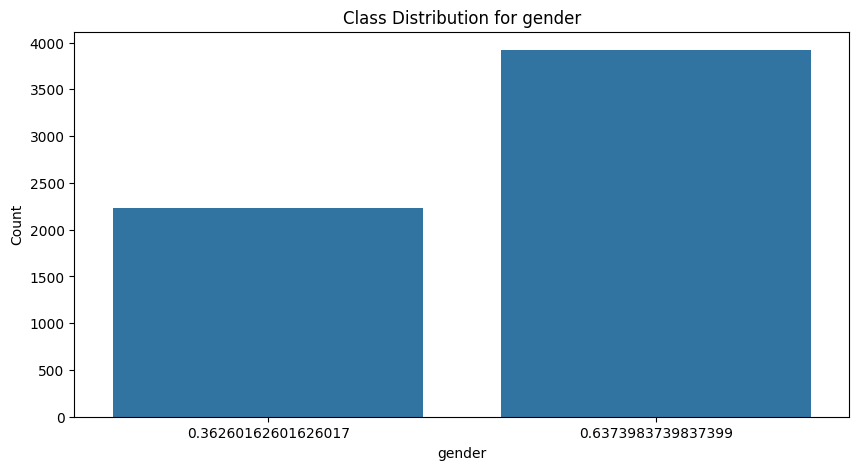

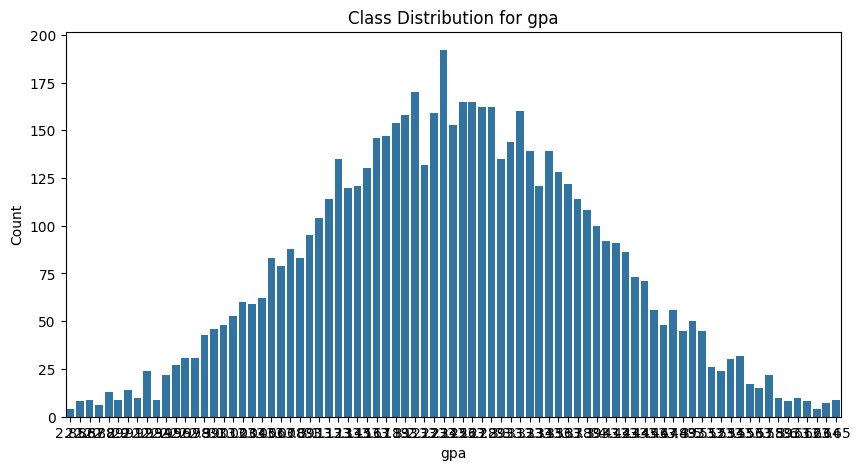

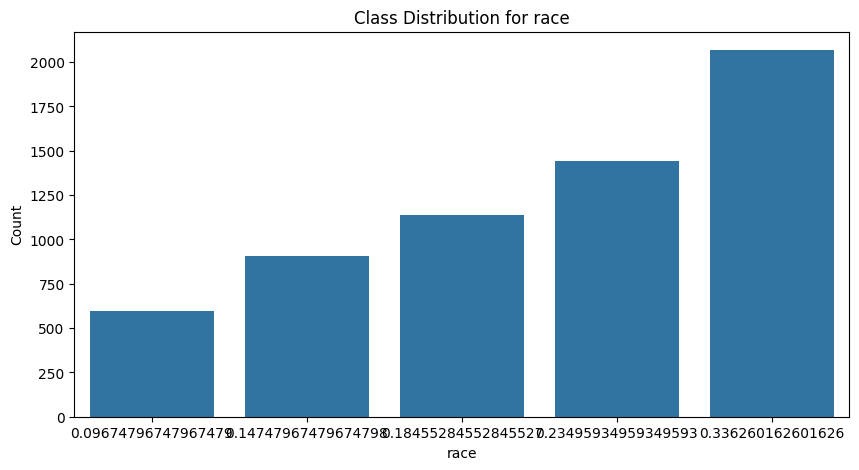

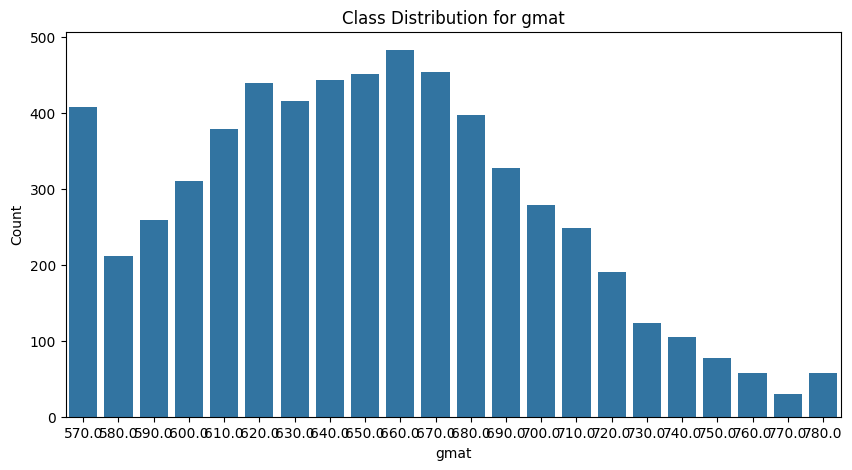

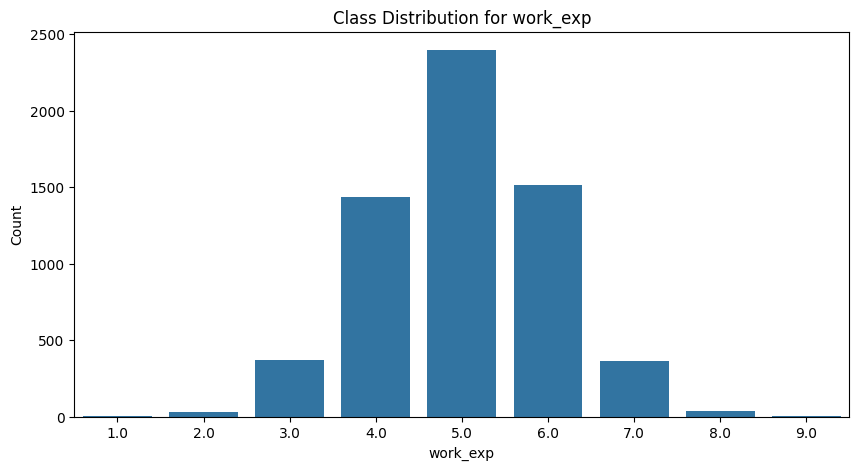

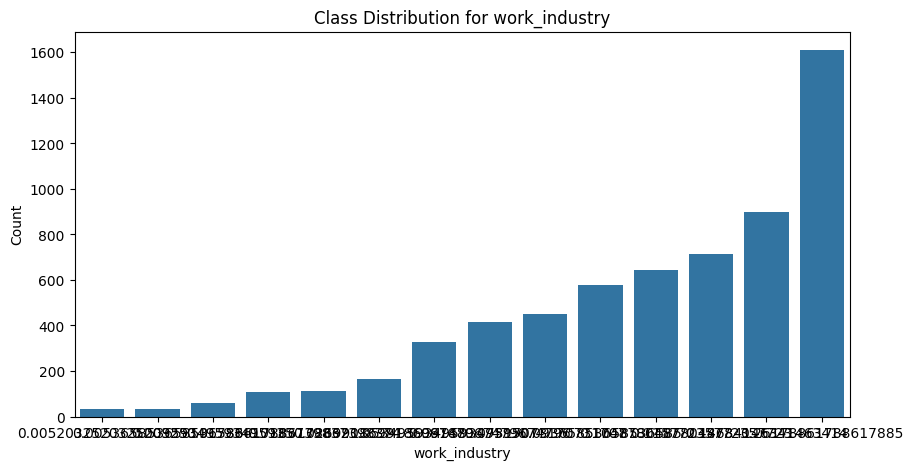

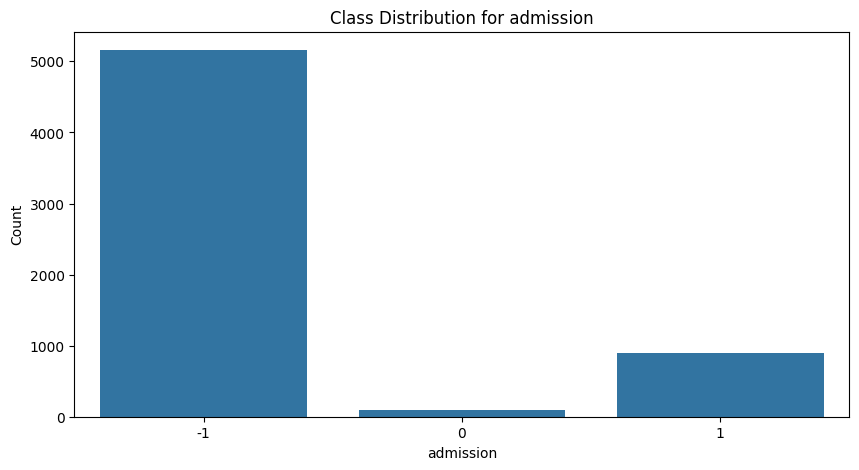

Admission class proportions:
admission
-1    0.838862
 1    0.144878
 0    0.016260
Name: proportion, dtype: float64


In [33]:
# Check new distribution of the updated dataframe regarding numerical features and  categorical featuers that are frequency encoded

# List of categorical features (remove categorical features here)
features = ['gender', 'gpa', 'race', 'gmat', 'work_exp', 'work_industry', 'admission']  # Replace with actual feature names


# Plot class distribution for each categorical feature
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df[feature])
    plt.title(f'Class Distribution for {feature}')
    plt.ylabel('Count')
    plt.xlabel(feature)
    plt.show()

# Check the proportions of each class in 'admission' (target variable)
admission_proportions = df['admission'].value_counts(normalize=True)
print("Admission class proportions:")
print(admission_proportions)


Since the categorical and numerical features are frequency encoded, this addresses the imbalances between them. The only problem now is to deal with imbalanced data on the target variable. Oversampling and Undersampling can be applied to address this.

In [34]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('admission', axis=1)
y = df['admission']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Random Undersampling to the training data
undersampler = RandomUnderSampler(random_state=42)
X_undersampling, y_undersampling = undersampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", y_undersampling.value_counts())

Original class distribution: admission
-1    4140
 1     702
 0      78
Name: count, dtype: int64
Resampled class distribution: admission
-1    78
 0    78
 1    78
Name: count, dtype: int64


In [35]:
# Oversampling
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_oversampling, y_oversampling = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", y_oversampling.value_counts())

Original class distribution: admission
-1    4140
 1     702
 0      78
Name: count, dtype: int64
Resampled class distribution: admission
 1    4140
 0    4140
-1    4140
Name: count, dtype: int64


In [36]:
# Use Cross-Validation:

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Initialize variables
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize metrics lists
results_oversampled = []
results_undersampled = []

# K-Fold Cross Validation for Oversampling
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_oversampling, y_oversampling)

    # Make predictions
    y_pred = model.predict(X_val)

    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    results_oversampled.append(accuracy)

# K-Fold Cross Validation for Undersampling
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_undersampling, y_undersampling)

    # Make predictions
    y_pred = model.predict(X_val)

    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    results_undersampled.append(accuracy)

# Print results
print("Oversampled Accuracy: Mean = {:.2f}, Std = {:.2f}".format(np.mean(results_oversampled), np.std(results_oversampled)))
print("Undersampled Accuracy: Mean = {:.2f}, Std = {:.2f}".format(np.mean(results_undersampled), np.std(results_undersampled)))

Oversampled Accuracy: Mean = 0.96, Std = 0.00
Undersampled Accuracy: Mean = 0.64, Std = 0.02


The results tell us that the Oversampled data has more accuracy than the Undersampled data and as such, the Oversampled data will be used as the final model if it performs better than the original dataset. Below is the evaluation of the impact of these techniques on the model's performance.

Model Building and Evaluation

In [37]:
# Evaluate the (1) Imbalanced Dataset, (2) Oversampled Dataset, and (3) Undersampled Dataset

# Train on Original Imbalanced Dataset
model_original = RandomForestClassifier(random_state=42)
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

# Evaluate Original Model
print("Performance on Original Dataset:")
print(classification_report(y_test, y_pred_original))

Performance on Original Dataset:
              precision    recall  f1-score   support

          -1       0.96      0.99      0.97      1019
           0       1.00      0.82      0.90        22
           1       0.92      0.80      0.86       189

    accuracy                           0.96      1230
   macro avg       0.96      0.87      0.91      1230
weighted avg       0.96      0.96      0.95      1230



In [38]:

# Train on Oversampled Dataset
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_oversampling, y_oversampling)
y_pred_smote = model_smote.predict(X_test)

# Evaluate SMOTE Model
print("\nPerformance on Oversampled Dataset:")
print(classification_report(y_test, y_pred_smote))


Performance on Oversampled Dataset:
              precision    recall  f1-score   support

          -1       0.88      0.89      0.89      1019
           0       0.00      0.00      0.00        22
           1       0.44      0.42      0.43       189

    accuracy                           0.81      1230
   macro avg       0.44      0.44      0.44      1230
weighted avg       0.80      0.81      0.80      1230



In [39]:

# Train on Undersampled Dataset
model_undersampled = RandomForestClassifier(random_state=42)
model_undersampled.fit(X_undersampling, y_undersampling)
y_pred_undersampled = model_undersampled.predict(X_test)

# Evaluate Undersampled Model
print("\nPerformance on Undersampled Dataset:")
print(classification_report(y_test, y_pred_undersampled))


Performance on Undersampled Dataset:
              precision    recall  f1-score   support

          -1       0.95      0.65      0.77      1019
           0       0.04      0.55      0.08        22
           1       0.37      0.51      0.43       189

    accuracy                           0.63      1230
   macro avg       0.46      0.57      0.43      1230
weighted avg       0.85      0.63      0.71      1230



Short Interpretation and Analysis

From the results above, it can be seen that the original dataset has the highest precision, recall, f1-score, and accuracy score out of the three. Following this is the oversampled dataset and lastly is the undersampled dataset.

Precision tells us that of all the students the model predicted as admitted, how many were actually admitted?

Recall tell us that of all the students who should have been admitted, how many did the model correctly predict as admitted?

F1 is the harmonic mean of precision and recall.

Accuracy tells us how many of the model's predictions (both admitted and not admitted) were correct overall?

Some of the strengths of Random Forest Classifier is its ability to handle non-linear data, which is also robust to overfitting because the model averages the results of multiple trees. However, the weakness of this model is interpretability since it is not a simpler interpretable model like Logistic Regression. Moreover, since the original dataset is used and not the oversampled and undersampled, it is prone to biaess in imbalanced data. Lastly, it is computationally expensive for very large datasets since as the number of trees and depth of the trees increase, training times and memory consumption grows.

A potential improvement if it is proven that GMAT and GPA scores have a linear relationship with admission is to use Logistic regression since a linear data needs a linear model related process. Grid Search may also be implemented for hyperparameter tuning tp find the optimal number of trees, maximum depth, and other hyperparameters. Lastly, feature interpretation methods such as SHAP may also be implemented to interpret individual predictions and understand the contributions of features in Random Forest.